In [1]:
import sqlite3
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import MessagesState, RemoveMessage

In [2]:
# !mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [3]:
# Here is our checkpointer 
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.4)

class State(MessagesState):
    summary: str

In [5]:
from langchain_core.messages import SystemMessage, HumanMessage

def call_model(state: State):
    summary = state.get("summary","")
    if summary:
        sys_msg = f"Summary of the Conversation Earlier: {summary}"
        messages = [SystemMessage(content=sys_msg)] + state["messages"]
    else:
        messages = state["messages"]
    
    response = llm.invoke(messages)

    return {"messages" : response}

In [6]:
def summarize_conversation(state:State):
    summary = state.get("summary", "")
    if summary:
        summary_message = (
            f"This Summary of the Conversation is to date: {summary}",
            "Extend the Summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the Conversation Above."
    
    messages = state["messages"] + [HumanMessage(content=summary_message)]

    response = llm.invoke(messages)

    deleted_messages = [RemoveMessage(msg.id) for msg in state["messages"][:-2]]

    return {
        "messages": deleted_messages,
        "summary": response.content
    }

def should_continue(state:State):
    messages = state["messages"]

    if len(messages) <= 6:
        return "summarize_conversation"
    
    return END

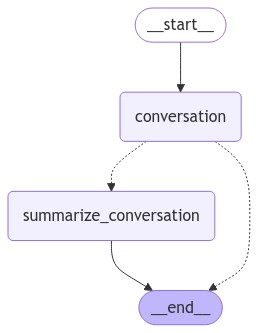

In [7]:
from IPython.display import display, Image

builder = StateGraph(State)

builder.add_node("conversation", call_model)
builder.add_node(summarize_conversation)

builder.add_edge(START, "conversation")
builder.add_conditional_edges("conversation", should_continue)
builder.add_edge("summarize_conversation", END)

graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [12]:
config = {"configurable" : {"thread_id" : "1"}}

input_message = HumanMessage(content="Hi, This is M.Ahsaan Abbasi.")
out_put = graph.invoke({"messages": [input_message]}, config)
for m in out_put["messages"][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="What is my Name?")
out_put = graph.invoke({"messages": [input_message]}, config)
for m in out_put["messages"][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="tell me about AI?")
out_put = graph.invoke({"messages": [input_message]}, config)
for m in out_put["messages"][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello, M. Ahsaan Abbasi! How can I assist you today?
================================== Ai Message ==================================

Your name is M. Ahsaan Abbasi. How can I help you today?
================================== Ai Message ==================================

Artificial Intelligence (AI) is a branch of computer science focused on creating systems capable of performing tasks that typically require human intelligence. Here are some key aspects of AI:

1. **Definition**: AI involves the development of algorithms and models that allow computers to perform tasks such as understanding natural language, recognizing patterns, solving problems, and making decisions.

2. **Types of AI**:
   - **Narrow AI**: Also known as weak AI, it is designed to perform a specific task (e.g., virtual assistants like Siri or Alexa).
   - **General AI**: Also known as strong AI, it refers to a theoretical form of AI t

In [9]:
config = {"configurable" : {"thread_id" : "1"}}
graph.get_state(config).values.get("summary", "")

'In the conversation, M. Ahsaan Abbasi introduces himself, and I respond by greeting him and offering assistance.'